In [1]:
import json
import pprint
from pathlib import Path
import sys
sys.path.insert(1, '../src/utils')
import ipdb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gensim.utils import simple_preprocess
from gensim import corpora, models
from gensim.models import Word2Vec
from gensim.models import CoherenceModel
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
from scipy.spatial.distance import cdist

from data import preprocessing

# Variables


In [31]:
num_topics = 5
use_title = True
# don't use stemming
stemming = False
lemmatization = True
# use nltk since it is a lot faster than spacy and the results are better with nltk
lib = "nltk"

input_path = Path("../src/data/data_jmlr_vol13-21.json")

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Data loading and preparation

## load

In [3]:
with open(input_path, encoding="utf-8") as f:
    data = json.load(f)
data_df = pd.json_normalize(data['papers'])
corpus = data_df["abstract"]
if use_title:
    corpus = data_df["title"] + " " + corpus 


c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## preprocess
TODO: save after preprocessing so that there is no need to wait for a long time

In [4]:
corpus = preprocessing(
    corpus,
    lib=lib,
    stemming=stemming,
    lemmatization=lemmatization,
    min_word_len=2,
    max_word_len=15
)

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Dropping 0 entries of corpus, due to nan ...


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
9it [00:00, 89.12it/s]

Starting tokenization ...


1261it [00:06, 206.96it/s]


### tfidf

The TfidfVectorizer does additionally also tokenization and stop word removal.

In [5]:
vectorizer_sklearn = TfidfVectorizer(stop_words='english')
tfidf_corpus_sklearn_preprocessed = vectorizer_sklearn.fit_transform(corpus["abstract"])

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Since we implemented our own preprocessing this is not necessary. Therefore we don't use tokenization and lowercase. Since we didn't implement stop word removal yet(TODO: false -> remove stopword removal by sklearn) we use the stopword removal by sklearn.

In [6]:
def identity_tokenizer(text):
    return text

vectorizer = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False)  
tfidf_corpus =  vectorizer.fit_transform(corpus["token"])  

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## get optimal k

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


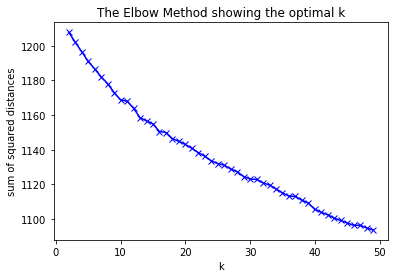

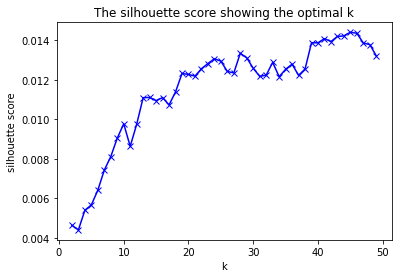

In [7]:
def find_k(corpus, num_topics):
    sum_of_suared_distances = []
    silhouette_scores = []
    K = range(2,num_topics)
    for k in K:
        model = KMeans(n_clusters=k, random_state=10)
        model.fit(corpus)
        sum_of_suared_distances.append(model.inertia_)
        labels = model.labels_
        silhouette_scores.append(metrics.silhouette_score(tfidf_corpus, labels, metric='euclidean'))

    # Plot the elbow
    plt.plot(K, sum_of_suared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('sum of squared distances')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

    # Plot silhouette scores
    plt.plot(K, silhouette_scores, 'bx-')
    plt.xlabel('k')
    plt.ylabel('silhouette score')
    plt.title('The silhouette score showing the optimal k')
    plt.show()
find_k(tfidf_corpus, 50)

 There is no elbow visible. There could be several reasons for this: https://stats.stackexchange.com/questions/89679/what-do-you-do-when-theres-no-elbow-point-for-kmeans-clustering

Silhouette score explained:
https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
TODO: proper visualization of silhouette score

Elbow Method explained: https://www.datanovia.com/en/lessons/determining-the-optimal-number-of-clusters-3-must-know-methods/

# Clustering

In [32]:
def fit_model(model, corpus):
    model.fit(corpus)

def print_clusters(model, vectorizer, n_components=None, svd=None):
    print("Top terms per cluster:")
    if n_components:
        original_space_centroids = svd.inverse_transform(model.cluster_centers_)
        order_centroids = original_space_centroids.argsort()[:, ::-1]
    else:
        order_centroids = model.cluster_centers_.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names()
    for i in range(num_topics):
        print("Cluster %d:" % i),
        for ind in order_centroids[i, :10]:
            print(' %s' % terms[ind])
        print("\n")
    
model = KMeans(n_clusters=num_topics, init='k-means++', max_iter=100, n_init=1)
fit_model(model, tfidf_corpus)
print_clusters(model, vectorizer)


c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Top terms per cluster:
Cluster 0:
 library
 python
 learning
 package
 machine
 source
 toolbox
 open
 implementation
 data


Cluster 1:
 network
 method
 gradient
 loss
 data
 algorithm
 regression
 stochastic
 function
 neural


Cluster 2:
 model
 inference
 data
 variable
 policy
 method
 algorithm
 bayesian
 gaussian
 causal


Cluster 3:
 learning
 kernel
 algorithm
 problem
 function
 bound
 convex
 graph
 optimization
 method


Cluster 4:
 matrix
 rank
 sparse
 low
 covariance
 method
 data
 completion
 algorithm
 tensor




Since the words which define the clusters look weird I use the sklearn preprocessing in the following. Our preprocessing should be improved. Or we decide to just use the sklearn preprocessing. But as far as I know they don't use lemmatization and stemming (TODO: true?)
With no stemming, the use of nltk and lowering the words, the result seems to be better. Therfore we use our own preprocessing again.

In [33]:
model_skelarn_preprocessed = KMeans(n_clusters=num_topics, init='k-means++', max_iter=100, n_init=1)
fit_model(model_skelarn_preprocessed, tfidf_corpus_sklearn_preprocessed)
print_clusters(model_skelarn_preprocessed, vectorizer_sklearn)


c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Top terms per cluster:
Cluster 0:
 python
 library
 source
 learning
 machine
 toolbox
 open
 package
 documentation
 algorithms


Cluster 1:
 optimization
 stochastic
 algorithms
 policy
 gradient
 learning
 algorithm
 convex
 convergence
 regret


Cluster 2:
 models
 model
 data
 inference
 gaussian
 latent
 networks
 bayesian
 causal
 graphical


Cluster 3:
 learning
 kernel
 data
 regression
 classification
 bounds
 function
 based
 sample
 feature


Cluster 4:
 matrix
 clustering
 rank
 graph
 sparse
 low
 data
 algorithm
 problem
 lasso




lemmatization would be good, because the defining words are redundant(e.g. models and model, graphs and graph, ...)

# Visualization

TODO: merge somehow with visualization of gensim_inspections? would be very difficult because of different inputs


c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


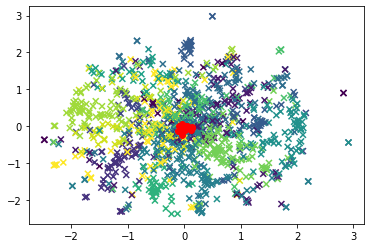

In [30]:
def plot(model, corpus, n_components=None):
    random_state = 1
    centroids = model.cluster_centers_

    tsne_init = 'pca'  # could also be 'random'
    tsne_perplexity = 20.0
    tsne_early_exaggeration = 4.0
    tsne_learning_rate = 10
    tsne = TSNE(n_components=2, random_state=random_state, init=tsne_init,
        perplexity=tsne_perplexity,
        early_exaggeration=tsne_early_exaggeration, learning_rate=tsne_learning_rate)
    if n_components:
        transformed = tsne.fit_transform(np.concatenate((corpus, centroids)))
    else:
        transformed = tsne.fit_transform(np.concatenate((corpus.todense(), centroids)))
    plt.scatter(transformed[:-num_topics, 0], transformed[:-num_topics, 1], c=model.labels_, marker='x')
    plt.scatter(transformed[-num_topics:, 0], transformed[-num_topics:, 1], c="red", marker='o')

    plt.show()
plot(model, tfidf_corpus)

# LSA and kmeans

In [15]:
def get_lsa_transformation(n_components, corpus):
    svd = TruncatedSVD(n_components)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)
    return lsa.fit_transform(corpus),svd

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


n_components:  2


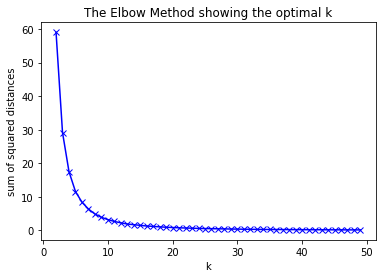

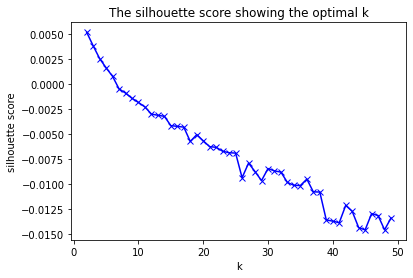

n_components:  3


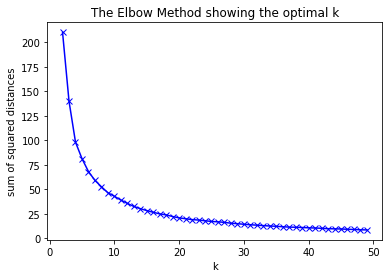

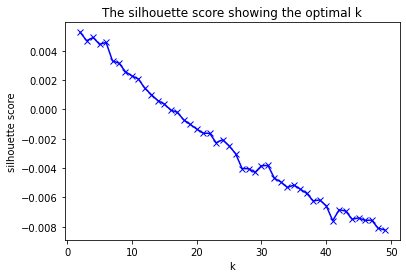

n_components:  4


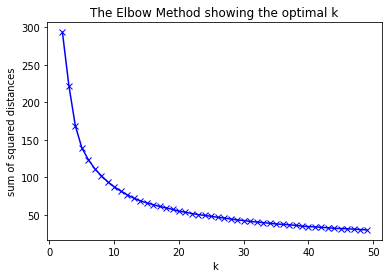

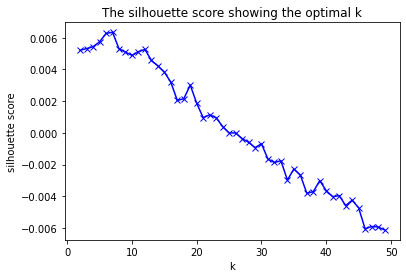

n_components:  5


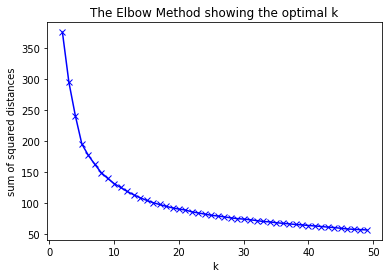

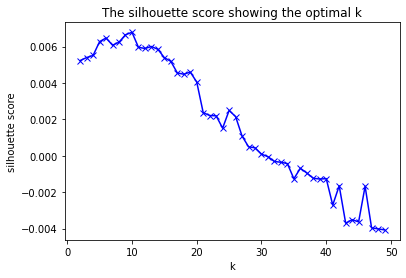

n_components:  6


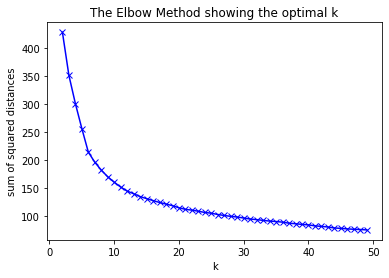

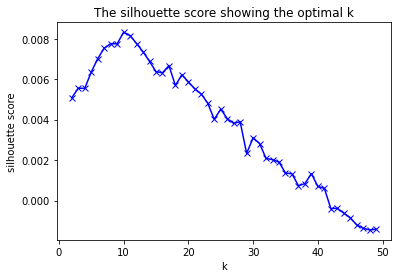

n_components:  7


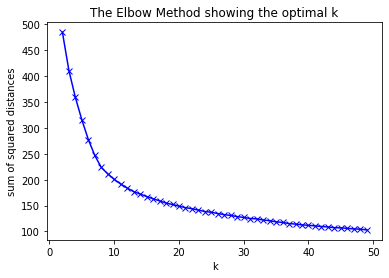

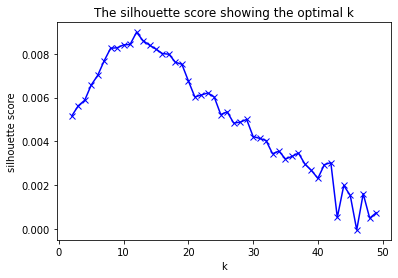

n_components:  8


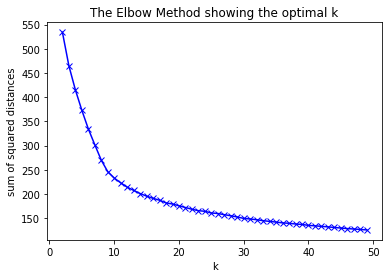

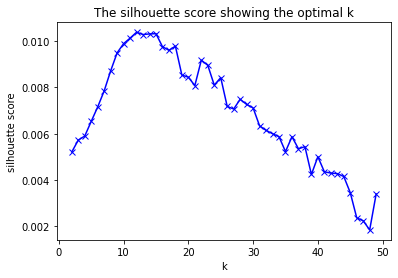

n_components:  9


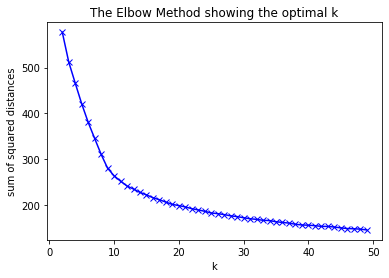

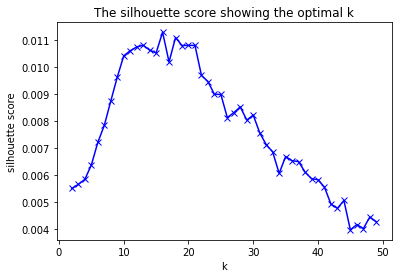

n_components:  10


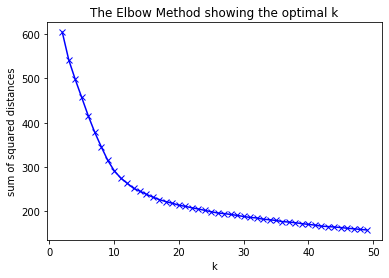

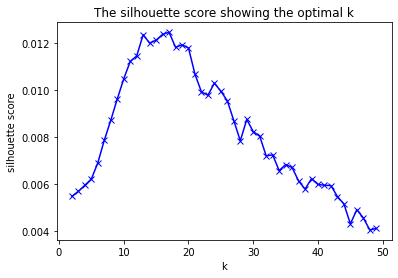

In [24]:
for n_components in [2,3,4,5,6,7,8,9,10]:
    print("n_components: ", n_components)
    X, svd = get_lsa_transformation(n_components, tfidf_corpus)
    find_k(X, 50)

With LSA and kmeans a elbow is visible! The peak of the silhouette score moves to the right the higher n_component.
The optimal cluster number seems to be 15? With n_components = 9 also the peak of the silhouette score is at k=15. So maybe use num_topics= 15 and n_components=9?

In [25]:
n_components = 9
X, svd = get_lsa_transformation(n_components, tfidf_corpus)
num_topics = 15
model = KMeans(n_clusters=num_topics, init='k-means++', max_iter=100, n_init=1)
fit_model(model, X)
print_clusters(model, vectorizer, n_components=n_components, svd=svd)


c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Top terms per cluster:
Cluster 0:
 regression
 model
 estimator
 method
 data
 rate
 selection
 estimation
 high
 loss


Cluster 1:
 algorithm
 matrix
 method
 problem
 learning
 data
 optimization
 convex
 clustering
 model


Cluster 2:
 matrix
 rank
 low
 completion
 tensor
 bound
 data
 norm
 sparse
 approximation


Cluster 3:
 policy
 learning
 algorithm
 bound
 distribution
 process
 reinforcement
 problem
 function
 action


Cluster 4:
 bound
 loss
 rate
 learning
 class
 sample
 optimal
 regression
 algorithm
 error


Cluster 5:
 learning
 data
 machine
 feature
 library
 classification
 task
 multi
 python
 label


Cluster 6:
 model
 inference
 gaussian
 method
 bayesian
 process
 data
 policy
 variable
 variational


Cluster 7:
 graph
 network
 model
 graphical
 algorithm
 node
 data
 community
 structure
 neural


Cluster 8:
 algorithm
 optimization
 gradient
 stochastic
 convex
 method
 problem
 function
 convergence
 descent


Cluster 9:
 graph
 clustering
 algorithm
 clust

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


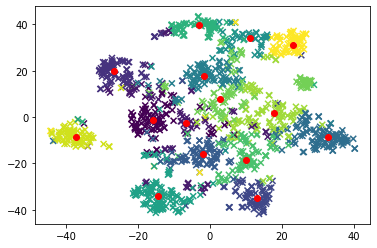

In [26]:
plot(model, X, n_components=n_components)

cluster centers look better than without lsa.

# Remove words which appear often in all clusters